# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

{}
$$ L(w) = \frac{1}{N}\left[\sum_i (\langle\,X_i,w\rangle - y_i) ^ 2 \right] + \frac{1}{C}\sum_{j=1}^{D}w_j^2 $$
$$ \nabla L = \frac{2}{N}\left[\sum_i (\langle\,X_i,w\rangle - y_i)X_i\right] + \frac{2w}{C} $$
$$ w_{new} = w_{old} - \alpha\nabla L $$
$$ w_{new} = w_{old} - 2\alpha(\frac{1}{N}\left[\sum_i (\langle\,X_i,w\rangle - y_i)X_i\right] + \frac{w_{old}}{C}) $$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

$$ L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}\sum_{j=1}^{D}w_j^2 $$
$$ L_1 = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] $$
$$ \nabla L_1 = - \frac{1}{N}\left[\sum_i \frac{y_i}{a_i}\frac{X_i}{1 + exp ^ 2(-\langle\,X_i,w\rangle)}e(-\langle\,X_i,w\rangle) -\frac{1 - y_i}{1-a_i}\frac{X_i}{1 + exp ^ 2(-\langle\,X_i,w\rangle)}e(-\langle\,X_i,w\rangle)\right] $$
$$ \nabla L_1 = - \frac{1}{N}\left[\sum_i \frac{y_i}{a_i}X_i a_i exp(-\langle\,X_i,w\rangle) -\frac{1 - y_i}{1-a_i}X_i a_i^2 exp(-\langle\,X_i,w\rangle) \right] $$
$$ \nabla L_1 = - \frac{1}{N}\left[\sum_i X_i a_i exp(-\langle\,X_i,w\rangle) (y_i-(1-y_i))\frac{a_i}{1-a_i} \right]$$
$$ y_i-(1-y_i))\frac{a_i}{1-a_i} = \frac{y_i-y_ia_i-a_i+y_ia_i}{1-a_i} = \frac{y_i-a_i}{1-a_i} $$
$$ \nabla L_1 = - \frac{1}{N}\left[\sum_i X_i a_i exp(-\langle\,X_i,w\rangle) \frac{y_i-a_i}{1-a_i}\right] $$
$$ 1 - a_i = 1 - \frac{1}{1+exp(-\langle\,X_i,w\rangle)}=\frac{1+exp(-\langle\,X_i,w\rangle)-1}{1+exp(-\langle\,X_i,w\rangle)}=\frac{exp(-\langle\,X_i,w\rangle)}{1+exp(-\langle\,X_i,w\rangle)}= exp(-\langle\,X_i,w\rangle)a_i $$
$$ \nabla L_1 = - \frac{1}{N}\left[\sum_i X_i a_i exp(-\langle\,X_i,w\rangle) \frac{y_i-a_i}{exp(-\langle\,X_i,w\rangle)a_i}\right] $$
$$ \nabla L_1 = - \frac{1}{N}\left[\sum_i X_i (y_i-a_i)\right]= \frac{1}{N}\left[\sum_i X_i(a_i-y_i) \right]$$
$$ \nabla L = \frac{1}{N}\left[\sum_i X_i(a_i-y_i) \right] +\frac{2w}{C} $$ 
$$ w_{new} = w_{old} -\alpha\nabla L = w_{old} -\alpha(\frac{1}{N}\left[\sum_i X_i(a_i-y_i) \right] +\frac{2w_{old}}{C}) $$ 

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

1)
$$ \nabla L = \frac{2}{N}\left[\sum_i (\langle\,X_i,w\rangle - y_i)X_i\right] + \frac{2w}{C} = = \frac{2}{N}(X^TXw - X^TY \frac{2w}{C}) $$
$$ H = \nabla \nabla L = \frac{2}{N}X^TX $$
$rg $X^TX = rg X, следовательно, X невырождена и столбцы $X^TХ$ линейно независимы

$X^TXv$ - линейная комбинация столбцов $Х^TX$
$$ X^TXv \neq 0 \;, \; если \;\; v \neq 0$$
$$ X^TXv = y $$
$$ X^TX - самосопряженная $$
$$(X^TXv, v) = v^TX^TXv = (Xv)^TXv = y^Ty = \sum_{j}y_{j}^2 \; > 0 $$
$$сл-но, X^TX $$ -положительно определена 

2.
$$L = L_1 + \frac{1}{C} R(w) $$
$$L = \frac{1}{N}\|X*w - Y\|^{2} + \frac{1}{C} R(w) $$
$$\|X*w - Y\|^{2} = (X*w - Y)^T(X*w - Y) $$
$$R(w) =  w^T*w $$
$$\nabla L = 2X^TXw - 2X^TY + \frac{2}{C} w = 0$$
$$(X^TX + \frac{1}{C}*I)w = X^TY $$
$$w = (X^TX + \frac{1}{C}*I)^{-1}X^TY $$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

$$ E(L) = -p*log(a) - (1 - p)*log(1 - a) $$
$$ E'(L) = -\frac{p}{a} + \frac{1 - p}{1 - a} = \frac{a - p}{1 - a} $$
$ E'(L) = 0 $ при a = p, < 0 при a < p, > 0 при a > p $$ $$
a = p - минимум E(L)

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

Не нужно, так как $w_0$ - значение при всех признаках, равных 0, то есть это смещение таргета. 
То есть на переобучение $w_0$ не влияет, а, значит, и в регуляризации он не участвует

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [142]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [143]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [144]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [145]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    #X_batch = ""
    #y_batch = ""
    indexes = range(X.shape[0])
    if(shuffle):
        indexes = np.random.permutation(X.shape[0])
    for i in range(X.shape[0] // batch_size):
        X_batch = X[indexes[batch_size * i : batch_size * (i + 1)], :]
        y_batch = y[indexes[batch_size * i : batch_size * (i + 1)]]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [3]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', batch_num=1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.batch_num = batch_num
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if(self.model_type == 'lin_reg'):
            A = np.dot(X_batch, self.weights) - y_batch
            loss = (A * A).sum() / X_batch.shape[0] + (self.weights[1:] * self.weights[1:]).sum() / self.C
        if(self.model_type == 'log_reg'):
            a = sigmoid(np.dot(X_batch, self.weights))
            A = np.log2(a)
            B = np.log2(1 - a)
            reg = (self.weights[1:] * self.weights[1:]).sum() / self.C
            loss = (np.dot(y_batch, A).sum() + np.dot(1 - y_batch, B).sum()) / (-X_batch.shape[0]) + reg
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
    def calc_loss_grad(self, X_batch, y_batch):
        if(self.model_type == 'lin_reg'):
            A = (np.dot(X_batch, self.weights) - y_batch) * 2
        if(self.model_type == 'log_reg'):
            A = sigmoid(np.dot(X_batch, self.weights)) - y_batch
        reg = np.concatenate((np.array([0]), self.weights[1:] * 2 / self.C))
        loss_grad = np.dot(A, X_batch) / X_batch.shape[0] + reg
        if(self.model_type == 'lin_reg'):
            return loss_grad / X_batch.shape[1]
        if(self.model_type == 'log_reg'):
            return loss_grad 
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - self.alpha * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        T = np.ones(X.shape[0]).reshape(-1, 1)
        X = np.concatenate((T, X), axis=1)
        # Нужно инициализровать случайно веса
        self.weights = np.ones(X.shape[1])
        
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, True, self.batch_num)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        T = np.ones(X.shape[0]).reshape(-1, 1)
        X = np.concatenate((T, X), axis=1)
        if(self.model_type == 'lin_reg'):
            y_hat = np.dot(X, self.weights)
        if(self.model_type == 'log_reg'):
            y_bool = sigmoid(np.dot(X, self.weights))# > 0.5 
            y_hat = y_bool
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [169]:
def plot_decision_boundary(clf):
    x = np.linspace(-1, 5, 100)
    w = clf.weights
    y = (-x * w[1] - w[0])  / w[2]
    ax.plot(x, y)

(array([-2.42084623,  0.6712042 , -0.51658396]),
 array([-1.25664055,  0.23891502, -0.34809658]))

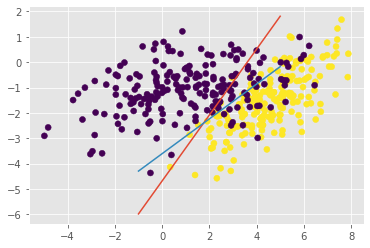

In [170]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

A = MySGDClassifier(batch_generator, C=1000, alpha=0.01, max_epoch=10, model_type='log_reg', batch_num=1).fit(X, y)
y = 2 * y - 1
B = MySGDClassifier(batch_generator, C=1000, alpha=0.01, max_epoch=10, model_type='lin_reg', batch_num=1).fit(X, y)

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
plot_decision_boundary(A)
plot_decision_boundary(B)

A.weights, B.weights

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [176]:
from sklearn.datasets import make_classification

In [177]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [209]:
def N_Mean(log):
    if log.size >= N:
        mean = log[:N].mean()
        flag = True
    else:
        mean = log.mean()
        flag = False
    return (mean, flag)

N = 1000
M = 6
points = []
alp = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
for i in range(M):
    points.append([])
    a = alp[i]
    my_class = MySGDClassifier(batch_generator, C=1000, alpha=a, max_epoch=10, model_type='log_reg', batch_num = 10).fit(X, y)
    log = np.array(my_class.errors_log['loss'])
    flag = True
    while flag:
        mean, flag = N_Mean(log)
        log = log[N:]
        if flag:
            points[i].append(mean)

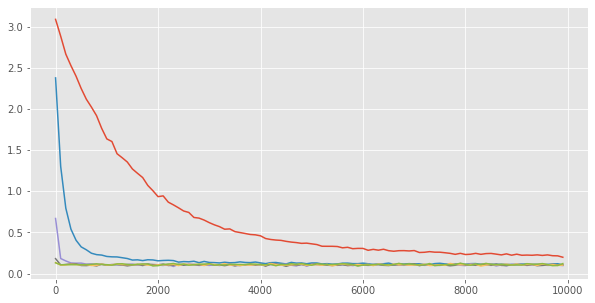

In [212]:
fig, ax = plt.subplots(figsize=(10, 5))
axis = np.array(range(100)) * 100
for i in range(6):
    ax.plot(axis, points[i])#list(points[i][j] for j in range(100)))

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

при слишком маленьких  $\alpha$  сходимость медленная, при больших -  решение неточное

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

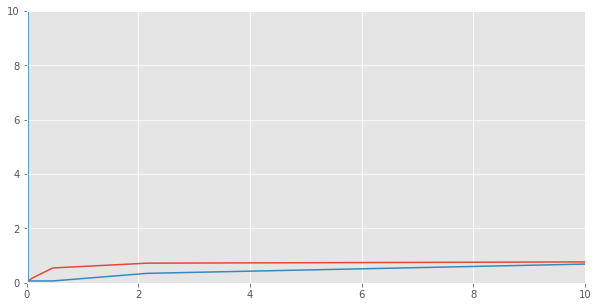

In [214]:
lin_mean = []
log_mean = []
C = np.logspace(3, -3, 10)
y_lin = 2 * y - 1
for c in C:
    log_class = MySGDClassifier(batch_generator, c, 0.01, 10, 'log_reg', 10000).fit(X, y)
    lin_class = MySGDClassifier(batch_generator, c, 0.01, 10, 'lin_reg', 10000).fit(X, y_lin)
    lin_mean.append(lin_class.weights.mean())
    log_mean.append(log_class.weights.mean())

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim(0, 10)
plt.ylim(0, 10)
ax.plot(C, lin_mean)
ax.plot(C, log_mean)

In [215]:
ax.plot(C, lin_mean)
ax.plot(C, log_mean)
lin_mean, log_mean, C

([0.7808941986253028,
  0.7804125925671825,
  0.7781856093830707,
  0.7679364035615187,
  0.7222306518087716,
  0.5456683538270832,
  0.17592649515767098,
  0.07103379455685327,
  0.07471897384606142,
  0.07553225918985783],
 [0.8357686949356502,
  0.8298023763509641,
  0.8026899461978038,
  0.6885824958236598,
  0.34774481785793404,
  0.06807544839549264,
  0.06891460397338166,
  0.07124545448040212,
  8.449777609927149e+51,
  6.823481456140713e+127],
 array([1.00000000e+03, 2.15443469e+02, 4.64158883e+01, 1.00000000e+01,
        2.15443469e+00, 4.64158883e-01, 1.00000000e-01, 2.15443469e-02,
        4.64158883e-03, 1.00000000e-03]))

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

при достаточно малых C веса уменьшаются, но при очень малых( <0.01) регуляризационное слагаемое в градиенте перевешивает ошибку и веса устремляются в бесконечность

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [4]:
import codecs
doc_to_title = {}
with codecs.open('docs_titles.tsv', 'r', 'utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [5]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [102]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [7]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [103]:
X_train = StandardScaler().fit_transform(X_train)
X_train.mean(), X_train.std()

(2.0746956413411536e-17, 1.0000000000000073)

In [76]:
%%time 
y_lin = y_train * 2 - 1
lin_class = MySGDClassifier(batch_generator, 1000, 0.33, 100,  'lin_reg', 1000).fit(X_train, y_lin)
log_class = MySGDClassifier(batch_generator, 1000, 0.33, 100, 'log_reg', 1000).fit(X_train, y_train)

Wall time: 526 ms


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [12]:
def Cv_Generator(i):
    ind1 = [groups_train != i]
    ind2 = [groups_train == i]
    return X_train[ind1], y_train[ind1], X_train[ind2], y_train[ind2]  

#cross-validation
arr = np.empty((10, 20, 5, 21, 2))
for c in range(10):
    for a in range(20):
        print("c = {}".format(c) + " a = {}".format(a))
        for epoch in range(5):
            alpha = 0.05 * (a + 1)
            lin_class = MySGDClassifier(batch_generator, c + 1, alpha, epoch + 1, 'lin_reg', 1000)
            log_class = MySGDClassifier(batch_generator, c + 1, alpha, epoch + 1, 'log_reg', 1000)
            scores = np.empty((129, 21, 2))
            for i in range(129):
                X_fit, y_fit, X_test, y_test  = Cv_Generator(i + 1)
                y_lin = y_train * 2 - 1
                lin = lin_class.fit(X_fit, y_lin).predict(X_test)
                lin = (lin + 1) / 2
                log = log_class.fit(X_fit, y_fit).predict(X_test)
                for t in range(21):
                    thres = 0.3 + t * 0.02
                    lin_pred = np.empty_like(lin)
                    log_pred = np.empty_like(log)
                    lin_pred[lin > thres] = 1
                    lin_pred[lin <= thres] = 0
                    log_pred[log > thres] = 1
                    log_pred[log <= thres] = 0
                    scores[i][t][0] = f1_score(lin_pred, y_test)
                    scores[i][t][1] = f1_score(log_pred, y_test)
            m = scores.mean(axis=0)
            arr[c][a][epoch] = m

c = 0 a = 0
c = 0 a = 1
c = 0 a = 2
c = 0 a = 3
c = 0 a = 4
c = 0 a = 5
c = 0 a = 6
c = 0 a = 7
c = 0 a = 8
c = 0 a = 9
c = 0 a = 10
c = 0 a = 11
c = 0 a = 12
c = 0 a = 13
c = 0 a = 14
c = 0 a = 15
c = 0 a = 16
c = 0 a = 17
c = 0 a = 18
c = 0 a = 19
c = 1 a = 0
c = 1 a = 1
c = 1 a = 2
c = 1 a = 3
c = 1 a = 4
c = 1 a = 5
c = 1 a = 6
c = 1 a = 7
c = 1 a = 8
c = 1 a = 9
c = 1 a = 10
c = 1 a = 11
c = 1 a = 12
c = 1 a = 13
c = 1 a = 14
c = 1 a = 15
c = 1 a = 16
c = 1 a = 17
c = 1 a = 18
c = 1 a = 19
c = 2 a = 0
c = 2 a = 1
c = 2 a = 2
c = 2 a = 3
c = 2 a = 4
c = 2 a = 5
c = 2 a = 6
c = 2 a = 7
c = 2 a = 8
c = 2 a = 9
c = 2 a = 10
c = 2 a = 11
c = 2 a = 12
c = 2 a = 13
c = 2 a = 14
c = 2 a = 15
c = 2 a = 16
c = 2 a = 17
c = 2 a = 18
c = 2 a = 19
c = 3 a = 0
c = 3 a = 1
c = 3 a = 2
c = 3 a = 3
c = 3 a = 4
c = 3 a = 5
c = 3 a = 6
c = 3 a = 7
c = 3 a = 8
c = 3 a = 9
c = 3 a = 10
c = 3 a = 11
c = 3 a = 12
c = 3 a = 13
c = 3 a = 14
c = 3 a = 15
c = 3 a = 16
c = 3 a = 17
c = 3 a = 18
c = 3 a = 19


In [129]:
ind = np.unravel_index(np.argmax(arr[:, :, :, :, 1]), arr[:, :, :, :, 1].shape)
c, a, epoch, t = ind

In [130]:
c + 1, 0.05 * (a + 1), epoch + 1, 0.3 + t * 0.02 #C, alpha, max_epoch, threshold

(8, 0.1, 3, 0.42)

In [111]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [135]:
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


In [136]:
X_test = StandardScaler().fit_transform(X_test)

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [137]:
import csv
myclf = MySGDClassifier(batch_generator, 8, 0.1, 3, 'log_reg', 1000)
myclf.fit(X_train, y_train)
pred = myclf.predict(X_test)
pred[pred > 0.42] = 1
pred[pred <= 0.42] = 0
pred = np.array(pred, dtype=int)

with open('sample_submission.csv', 'w') as f:
    fieldnames = ['pair_id', 'target']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    i = 11691
    for elem in pred:
        writer.writerow({'pair_id': str(i), 'target': str(elem)})
        i += 1
f.close()

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***